# Participez à la conception d'une voiture autonome - Data_Generator 

**Future vision transport** est une entreprise qui conçoit des systèmes embarqués de vision par ordinateur pour les véhicules autonomes.

Je suis l’un des ingénieurs IA au sein de l’équipe R&D de cette entreprise, membre de l equipe **Segmentation des images**:

    - acquisition des images en temps réel
    - traitement des images
    - segmentation des images (c’est vous !)
    - système de décision


Le but de ce projet est de concevoir un premier modèle de segmentation d’images qui devra s’intégrer facilement dans la chaîne complète du système embarqué.

Mon rôle ici est de fournir à l équipe en charge du système de décision (4), une API simple à utiliser qui prend en entrée une image et renvoie la segmentation de l’image de l’algo.

Pour ça, on utilisera le jeu de données CityScapes.

## Conception du Data generator

Dans ce notebook, l'objectif est de **concevoir notre Data_Generator**, servant à faciliter la manipulation du jeu de données lors des phases d'entrainement et de tests.

2 Chapitres distincts:
1. Analyse des données
2. Création du Data Generator (sous forme de classe python, entièrement automatisé)

Une fois finalisé, nous sauvegarderons notre data_generator dans notre fichier recensant les fonctions "Functions_custo_by_Nico.py", pour une réutilisation ultérieure lors de l'entrainement du modèle UNET.


In [16]:
#Import functions createdon my side
from Functions_custo_by_Nico import * 
#import seaborn
#from matplotlib.image import imread

#Import functions created
from labels import *
from labels import labels, name2label, id2label, trainId2label

import cv2
import albumentations as A
# calling functions
Test_Imported_Functions()


Functions have been properly imported !


## 1. Analyse des données

Le jeu de donnée est disponible en télechargement [ici](https://www.cityscapes-dataset.com/dataset-overview/).

Dans le chapitre suivant, nous executerons les 3 travaux :

  - 1.a. Lecture des données
  - 1.b. Analyse des données
  - 1.c. Nettoyage des données

Le Jeu de donnée est cronstruit de la façon suivante :
- `gtFine/` : Dossier contenant les images transformées
  - `test/`, `train/` and `val/` : 3 Dossiers pour différencier les jeux de données
    - `berlin/`, `frankfurt/`, `munich/`, ... : Dossiers par villes, contenant les images
      - `*_gtFine_color.png` : Images colorées
      - `*_gtFine_instanceIds.png` : Images avec faible variations de gris, suivant les InstanceIds
      - `*_gtFine_labelIds.png` : Images avec faible variations de gris, suivant les labelIds
      - `*_gtFine_polygons.json` : JSON contenant les formes ploygones associés aux images
- `leftImg8bit` : Dossier contenant les images natives
  - `test/`, `train/` and `val/` : 3 Dossiers pour différencier les jeux de données
    - `berlin/`, `frankfurt/`, `munich/`, ... : Dossiers par villes, contenant les images
      - `*_leftImg8bit.png` : Images natives variations de gris

### 1.a. Lecture des données

Nous préparons ici les chemins d'accès aux données

In [3]:
src_path = os.path.abspath(os.path.join("../IA_Project8_Openclassrooms_VoitureAutonome"))
if src_path not in sys.path:
    sys.path.append(src_path)

#Build Data path
data_url_gtfine = os.path.join(src_path, "Dataset", "P8_Cityscapes_gtFine_trainvaltest", "gtFine")
data_url_leftlmg = os.path.join(src_path, "Dataset", "P8_Cityscapes_leftImg8bit_trainvaltest", "leftImg8bit")

### 1.b. Analyse des données

Nous listons ici tous les fichiers, et stockons les informations dans un dataframe, pour une future utilisation

In [4]:
df_gtfine = list_files(data_url_gtfine)
df_leftlmg = list_files(data_url_leftlmg)
df = pd.concat([df_gtfine, df_leftlmg], ignore_index = None, axis = 0)
df = get_info_from_filename(df)
df.head(2)

,Phase,City,File,Path,File_id1,File_id2,File_type,File_unique_index
0,test,berlin,berlin_000000_000019_gtFine_color.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,000000,000019,gtFine,berlin_000000_000019
1,test,berlin,berlin_000000_000019_gtFine_instanceIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,000000,000019,gtFine,berlin_000000_000019


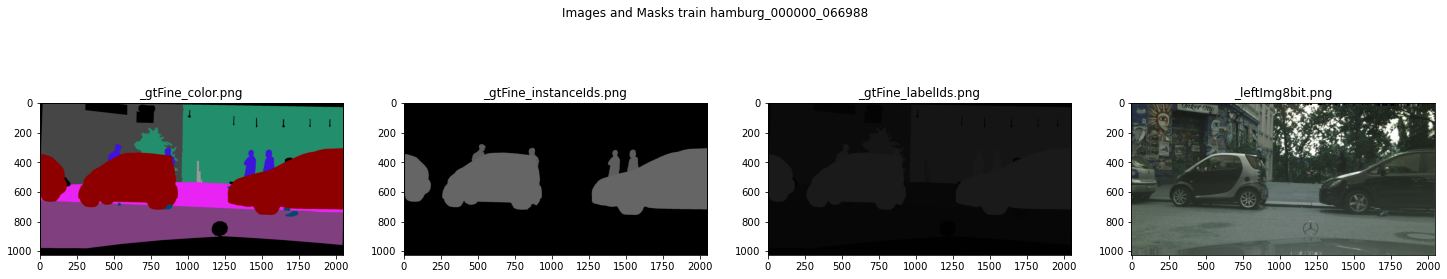

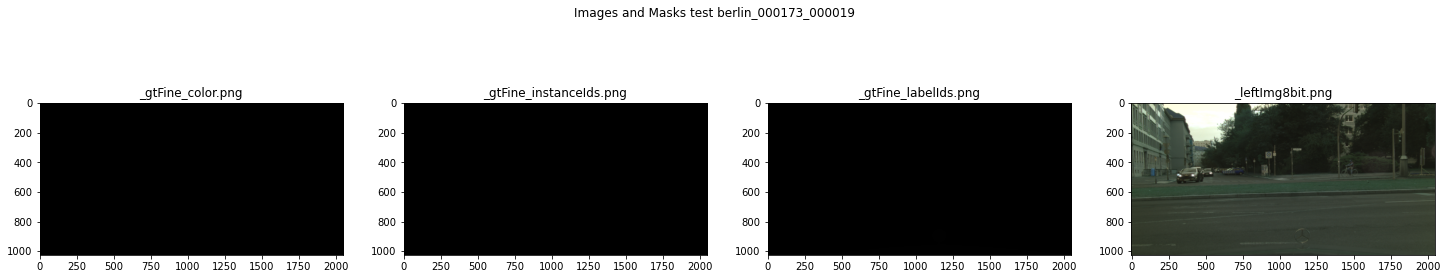

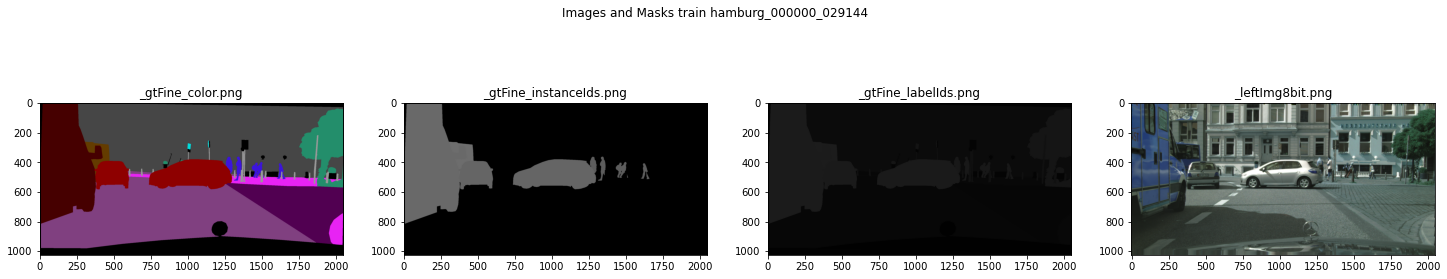

In [5]:
#Prendre un echantillon aléatoire, et afficher les photos appartenant à la même prise de vue, mais ayant subit différentes transformations
n_sample = 3
files_ids_random = df.loc[df['File_type'] == 'gtFine',:].sample(n_sample)
files_ids_random.drop_duplicates(keep='first', inplace=True)
title=['_gtFine_color.png', '_gtFine_instanceIds.png', '_gtFine_labelIds.png', '_leftImg8bit.png']
for i in files_ids_random.values:
    sources_images = df.loc[((df['Phase'] == i[0]) & (df['City'] == i[1]) & (df['File_id1'] == i[4]) & (df['File_id2'] == i[5])),:].sort_values(by=['File_type'])
    path_gtfine_color = os.path.join(data_url_gtfine, i[0], i[1], i[1] + '_' + i[4] + '_' + i[5] + '_gtFine_color.png')
    path_gtfine_instanceIds = os.path.join(data_url_gtfine, i[0], i[1], i[1] + '_' + i[4] + '_' + i[5] + '_gtFine_instanceIds.png')
    path_gtfine_labelIds = os.path.join(data_url_gtfine, i[0], i[1], i[1] + '_' + i[4] + '_' + i[5] + '_gtFine_labelIds.png')
    path_leftlmg = os.path.join(data_url_leftlmg, i[0], i[1], i[1] + '_' + i[4] + '_' + i[5] + '_leftImg8bit.png')
    filepaths = [path_gtfine_color, path_gtfine_instanceIds, path_gtfine_labelIds, path_leftlmg]
    plt.figure(figsize=(25, 5))
    plt.subplots_adjust(hspace=0.5)
    for j in range(4):
        #print(filepaths[j])
        plt.subplot(140 + 1 + j)
        plt.title(title[j])
        image = cv2.imread(filepaths[j])
        plt.imshow(image)
        plt.grid(False)
    plt.suptitle(f'Images and Masks {(i[0])} {(i[1])}_{(i[4])}_{(i[5])}')
    plt.show()

### 1.c. Nettoyage des données

Dans le sous-cahpitre suivant, nous allons conserver et associer les Images avec les Masques LabelIds.

In [6]:
clean_df = link_images_masks(df_gtfine, df_leftlmg)
clean_df.head(2)

,Phase,City,File_x,Path_x,File_id1,File_id2,File_type_x,File_unique_index,File_y,Path_y,File_type_y
0,test,berlin,berlin_000000_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,000000,000019,leftImg8bit.png,berlin_000000_000019,berlin_000000_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine
1,test,berlin,berlin_000001_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,000001,000019,leftImg8bit.png,berlin_000001_000019,berlin_000001_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine


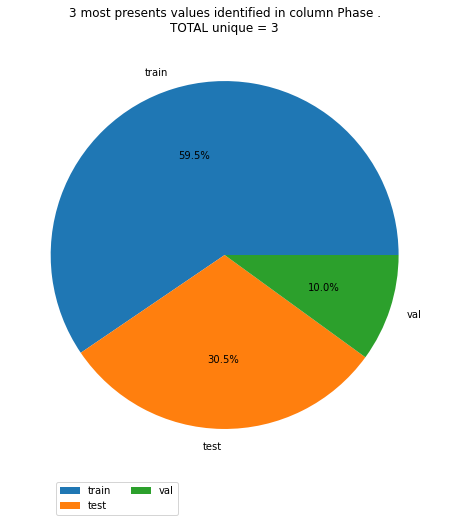

,Phase
train,2975
test,1525
val,500


In [7]:
#Représenter le % des données, par train, val et test
plot_ntops_pie(clean_df, 'Phase', 3, False, False)

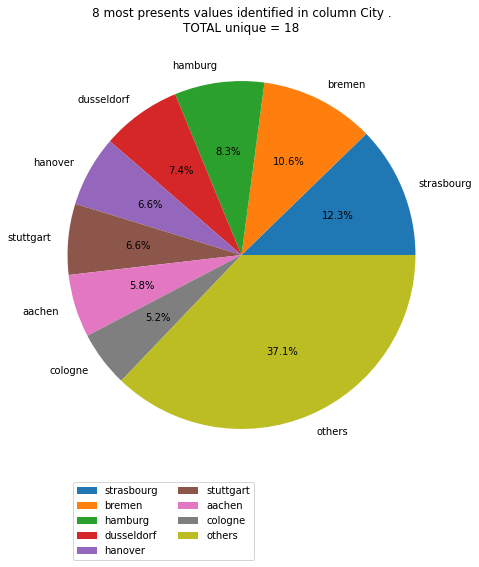

,City
strasbourg,365
bremen,316
hamburg,248
dusseldorf,221
hanover,196
stuttgart,196
aachen,174
cologne,154
others,1105


In [8]:
#Représenter le % des données d'entrainement, pour les 8 villes les plus représentés
plot_ntops_pie(clean_df.loc[clean_df['Phase'] == 'train', :], 'City', 8, True, False)

In [9]:
#Représenter la proportion des données par ville
#plot_occurence_line(clean_df, 'City')

In [10]:
clean_df.to_csv('./clean_df.csv')

In [11]:
clean_df.head(2)

,Phase,City,File_x,Path_x,File_id1,File_id2,File_type_x,File_unique_index,File_y,Path_y,File_type_y
0,test,berlin,berlin_000000_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,000000,000019,leftImg8bit.png,berlin_000000_000019,berlin_000000_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine
1,test,berlin,berlin_000001_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,000001,000019,leftImg8bit.png,berlin_000001_000019,berlin_000001_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine


## 2. Construction du Data_Generator

Afin d'entrainer notre futur réseau de neurones, il est essentiel de considérer le volume du jeu de données et les limitations mémoires.

Ainsi, nous devons utiliser un data_generator qui créé des donnée en batches et qui alimentera notre réseau lors de la phase d'entrainement.

Dans le chapitre ci-dessous, nous allons **concevoir une data_generator** capable d'alimenter nos modèles de segmentation, **à partir du dataframe créé ci-dessus (clean_df)**

Diffférentes documentation disponible:

- [Step by Step Data Generator - Skeleton](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)
- [Custom Data Generator - En Français](https://deeplylearning.fr/cours-pratiques-deep-learning/realiser-son-propre-generateur-de-donnees/)

Nous allons découper ce chapitre du  notebook en 3 parties distinctes:
- 2.a. Data Generator 1ere version (Création de la Class - Affichages des Images et Masques, avec Augmentations et Normalisation)
- 2.b. Conversion des Masques
- 2.c. Data Generator 2nde version (Insertion de la conversion des Masques)

### 2.a. Data Generator 1ere version (Création de la Class - Affichages des Images et Masques, avec Augmentations et Normalisation)

In [12]:
# # DATALOADER - Cett classe est créée et détaillée dans le fichier Function_custo_by_Nico
# class Dataloader_simple(keras.utils.Sequence):


In [17]:
# Divide the number of images in directory by batch_size 
n_sample = 20 #Pour les tests, nous limitons le jeu de données à 20 images
batch_size = 2 #Pour les tests, nous limitons le batch_size à 2 images
shuffle = True #La fonction shuffle permet de mélanger les images de manière aléatoire, à chaque lancement du data_generator  
resize = True #La fonction resize permet de redimensionner les images et les masques à la taille souhaitée (voir ci-dessous)
resize_width = 512
resize_height = 256
display_image_mask = True
phase = 'train'

# Declare an augmentation pipeline
# augmentation = None 
augmentation = A.Compose(
                    [#A.RandomCrop(width=512, height=256), 
                    A.Rotate(25),
                    A.OneOf([A.RGBShift(), A.HueSaturationValue()]),
                    #A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0), 
                    #A.IAAPerspective(p=0.5), 
                    #A.HorizontalFlip(p=0.5),
                    A.OneOf([A.CLAHE(), A.RandomBrightnessContrast(), A.RandomGamma()]), 
                    ])

normalization = True
dataloader = Dataloader_simple(clean_df, n_sample, batch_size, shuffle, resize, resize_width, resize_height, display_image_mask, phase, augmentation, normalization)


In [18]:
# Denotes the number of batches per epoch = Number of picture / batch_size
len(dataloader)


10

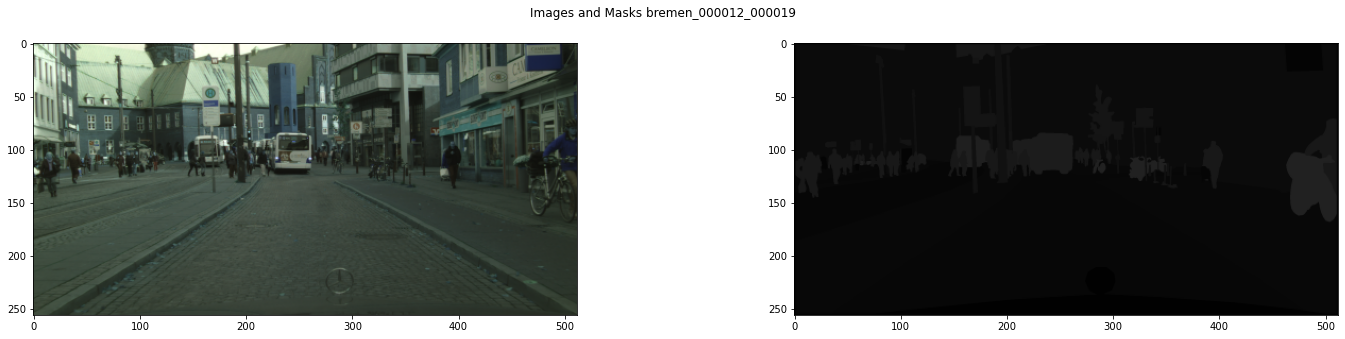

original height was  1024  and new height is  256
original width was  2048  and new width is  512
original channels was  3  and new channels is  3
----------------Normalized Image and Mask 0 from batch collected-----------------


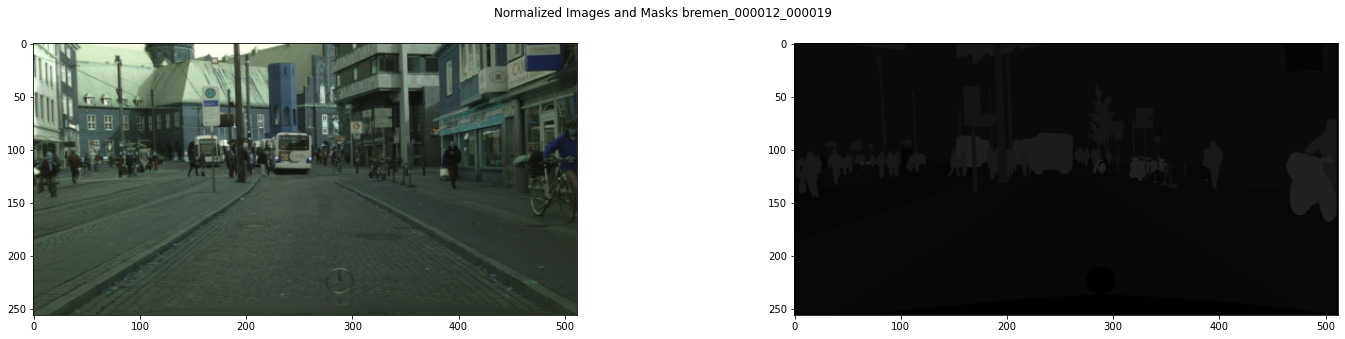

----------------Augmented Image and Mask 0 from batch collected-----------------


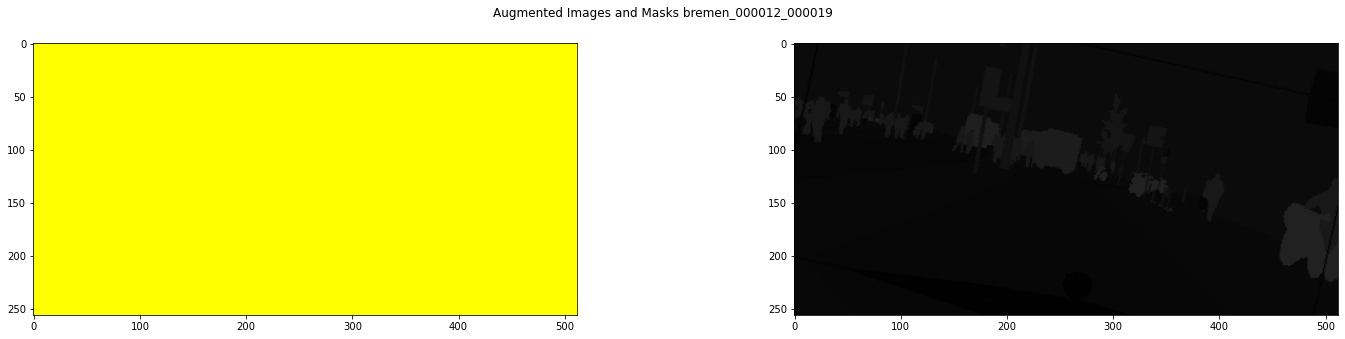

---------------- Image and Mask 0 from batch collected in Data Generator-----------------


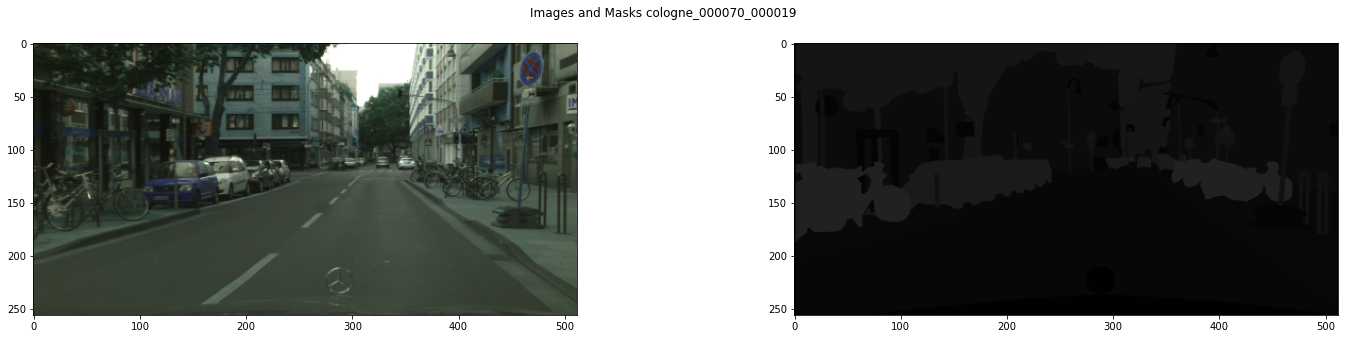

original height was  1024  and new height is  256
original width was  2048  and new width is  512
original channels was  3  and new channels is  3
----------------Normalized Image and Mask 1 from batch collected-----------------


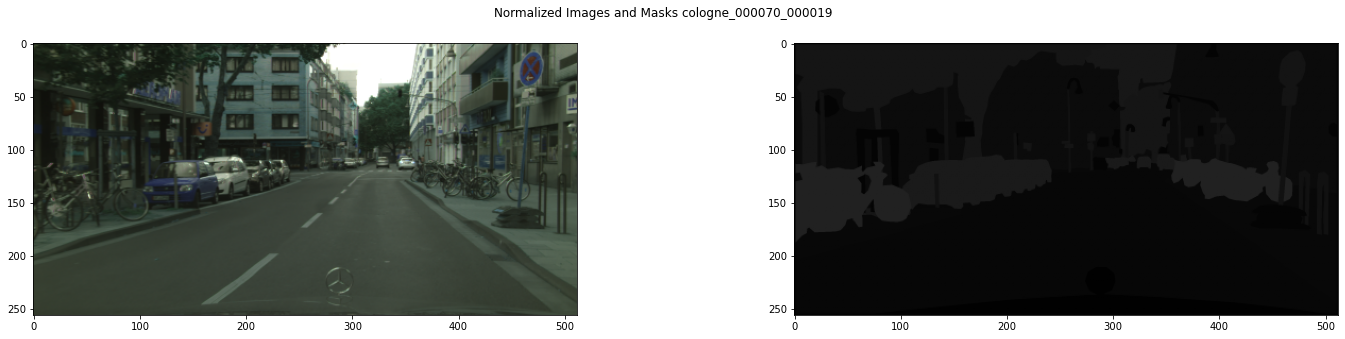

----------------Augmented Image and Mask 1 from batch collected-----------------


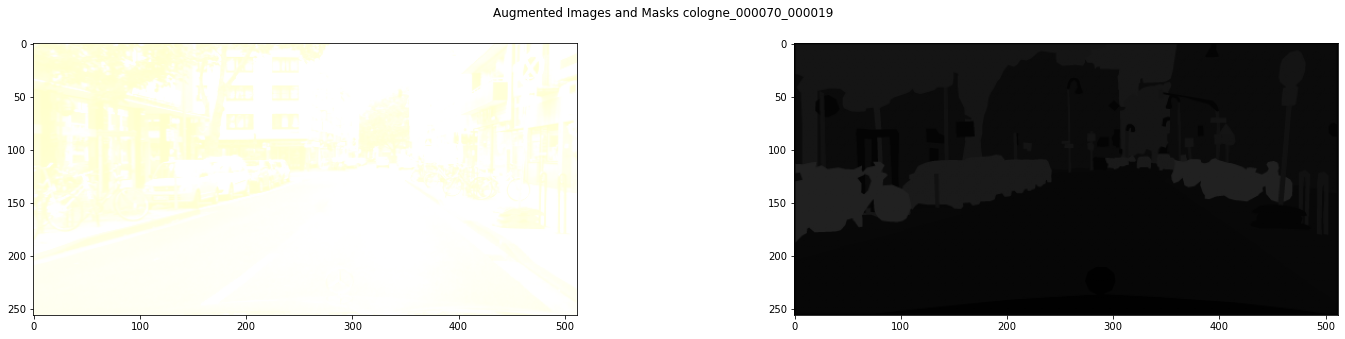

---------------- Image and Mask 1 from batch collected in Data Generator-----------------


(4, 256, 512, 3)

In [19]:
# Each dataloade call requests a batch index between 0 and the total number of batches, as specified in len(dataloader)

# This returns the images and mask for batch 0 numpy array
#image_batch, mask_batch = dataloader[0]

#This returns image_batch and mask_batch shapes
dataloader[0][0].shape

Au travers du test ci-dessus, nous notons que :
 - Le format du Data Loader retourne bien les images et les masques associés, pour chaque batch
 - Les Images et masques sont correctement redimensionnés (height, Width, Channel)
 - Les Images et Masques sont augmentés (pour les données d'entrainement)


### 2.b. Conversion des categories / classes

Tout d'abord, nous cherchons à comprendre la structure des couleurs des fichiers labelIds, [Voir Source GitHub](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py)

Nous notons par cet exercice, que **34 classes distinctes sont représentées**.
Notre objectifs est de **travailler un segmentation à 8** , nous devons donc renommer/convertirs des 34classes en 8classes.

Voici les 8 classes attendues: 
 - "void"
 - "flat"
 - "construction"
 - "object"
 - "nature"
 - "sky"
 - "human"
 - "vehicle"


 Nous allons ci-dessous chercher à convertir nos masques, en utilisant le dictionnaire de Conversion (ID to CatID) disponible

In [15]:
    from labels import labels, name2label, id2label, trainId2label
    # # Example usages:
    # # Map from name to label
    # name = 'ego vehicle'
    # print(labels[id])
    # id   = name2label[name].id
    # print("ID of label '{name}': {id}".format( name=name, id=id ))

    # # Map from trainID to label
    # trainId = 0
    # name = trainId2label[trainId].name
    # print("Name of label with trainID '{id}': {name}".format( id=trainId, name=name ))

    id = 4
    # Map from id to catId
    catId = id2label[id].categoryId
    print("CategoryID of id '{id}': {catId}".format( id=id, catId=catId ))

    # Map from ID to label
    category = id2label[id].category
    print("Category of label with ID '{id}': {category}".format( id=id, category=category ))

CategoryID of id '4': 0
Category of label with ID '4': void


In [16]:
def convert(list):
    return tuple(list)
def count_color_rgb(image):
    all_color = {}
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            color =  convert(image[x,y].tolist())
            if not color in all_color.keys():
                all_color[color] = 1
            else:
                all_color[color] += 1
    return sorted(all_color.items())


In [17]:
# Nous vérifions sur un exemple la structure du fichier, en comptabilisant les pixels par IDs
i = 2500
print(list(clean_df['Path_y'])[i])

# Open mask image
mask_test = cv2.imread(list(clean_df['Path_y'])[i])
# Count the number of unique Categories in the mask -=(34 in total)
count_color_rgb(mask_test)

c:\Users\blanc\OpenClassrooms\IA_Project8_Openclassrooms_VoitureAutonome\Dataset\P8_Cityscapes_gtFine_trainvaltest\gtFine\train\dusseldorf\dusseldorf_000150_000019_gtFine_labelIds.png


[((1, 1, 1), 81534),
 ((3, 3, 3), 31634),
 ((4, 4, 4), 64965),
 ((5, 5, 5), 5697),
 ((7, 7, 7), 849983),
 ((8, 8, 8), 19154),
 ((9, 9, 9), 54851),
 ((11, 11, 11), 700926),
 ((17, 17, 17), 6936),
 ((19, 19, 19), 3228),
 ((20, 20, 20), 11847),
 ((21, 21, 21), 47136),
 ((23, 23, 23), 89686),
 ((24, 24, 24), 1997),
 ((26, 26, 26), 122288),
 ((33, 33, 33), 5290)]

In [18]:
# Après réduction de dimensions, nous regardons le format de l'image en numpy array
mask_test_resized = cv2.resize(mask_test, (10, 10), interpolation = cv2.INTER_AREA)
mask_test_resized

array([[[10, 10, 10],
        [11, 11, 11],
        [11, 11, 11],
        [15, 15, 15],
        [22, 22, 22],
        [22, 22, 22],
        [12, 12, 12],
        [11, 11, 11],
        [10, 10, 10],
        [ 8,  8,  8]],

       [[11, 11, 11],
        [11, 11, 11],
        [10, 10, 10],
        [12, 12, 12],
        [20, 20, 20],
        [20, 20, 20],
        [11, 11, 11],
        [11, 11, 11],
        [ 9,  9,  9],
        [ 9,  9,  9]],

       [[11, 11, 11],
        [11, 11, 11],
        [ 9,  9,  9],
        [11, 11, 11],
        [21, 21, 21],
        [15, 15, 15],
        [11, 11, 11],
        [13, 13, 13],
        [10, 10, 10],
        [10, 10, 10]],

       [[11, 11, 11],
        [11, 11, 11],
        [11, 11, 11],
        [ 9,  9,  9],
        [18, 18, 18],
        [13, 13, 13],
        [12, 12, 12],
        [13, 13, 13],
        [11, 11, 11],
        [11, 11, 11]],

       [[20, 20, 20],
        [20, 20, 20],
        [22, 22, 22],
        [15, 15, 15],
        [19, 19, 19],
  

In [20]:
# Après réduction de dimension, nous convertissons chaque pixel en utilisant le dictionnaire de compatibilité
#onehotencoder = False
mask_test_resized_converted = convert_mask(mask_test_resized)
mask_test_resized_converted

(10, 10, 8)


array([[1, 2, 2, 2, 4, 4, 2, 2, 1, 1],
       [2, 2, 1, 2, 3, 3, 2, 2, 1, 1],
       [2, 2, 1, 2, 4, 2, 2, 2, 1, 1],
       [2, 2, 2, 1, 3, 2, 2, 2, 2, 2],
       [3, 3, 4, 2, 3, 2, 4, 5, 1, 1],
       [4, 2, 1, 1, 1, 1, 1, 2, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

(1024, 2048, 8)


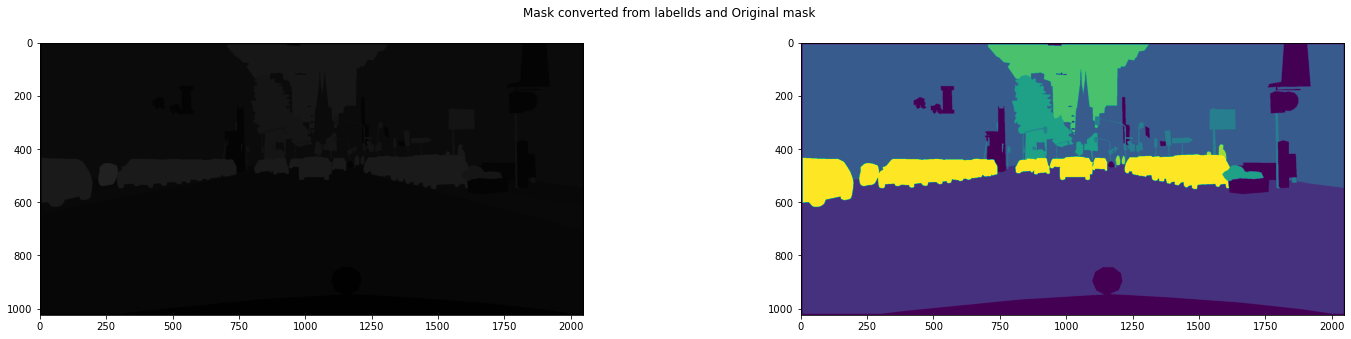

In [21]:
# Nous visualisons les couleurs du masques après conversion
mask_test = cv2.imread(list(clean_df['Path_y'])[i])
mask_converted = convert_mask(mask_test)

plt.figure(figsize=(25, 5))
plt.subplots_adjust(hspace=0.5)
plt.subplot(120 + 1 + 0)
plt.imshow(mask_test)
plt.subplot(120 + 1 + 1)
plt.imshow(mask_converted)
plt.grid(False)
plt.suptitle(f'Mask converted from labelIds and Original mask')
plt.show()

Comme il est précisé dans l'énnoncé du projet, il est essentiel de travailler autour des 8 catégories principales.

Ainsi, nous allons reprendre notre Data Generator 1ere version, afin qu'il prenne en charge la Conversion des masques LabelIds.png dans les 8 catégories.

### 2.c. Data Generator 2nde version (Inclure la conversion des Masques en 8 categories)



In [22]:
# # DATALOADER - Cette classe est définie dans le fichier Functions_custo_by_Nico.py
# class Dataloader_advanced(keras.utils.Sequence):


In [20]:
# Divide the number of images in directory by batch_size 
n_sample = 20 #Pour les tests, nous limitons le jeu de données à 20 images
batch_size = 2 #Pour les tests, nous limitons le batch_size à 2 images
shuffle = True #La fonction shuffle permet de mélanger les images de manière aléatoire, à chaque lancement du data_generator  
resize = True #La fonction resize permet de redimensionner les images et les masques à la taille souhaitée (voir ci-dessous)
resize_width = 512
resize_height = 256
convert = True
display_image_mask = True
phase = 'train'

# Declare an augmentation pipeline
# augmentation = None 
augmentation = A.Compose(
                    [#A.RandomCrop(width=512, height=256), 
                    A.Rotate(25),
                    A.OneOf([A.RGBShift(), A.HueSaturationValue()]),
                    #A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0), 
                    #A.IAAPerspective(p=0.5), 
                    #A.HorizontalFlip(p=0.5),
                    A.OneOf([A.CLAHE(), A.RandomBrightnessContrast(), A.RandomGamma()]), 
                    ])

normalization = True
dataloader = Dataloader_advanced(clean_df, n_sample, batch_size, shuffle, resize, resize_width, resize_height, convert, display_image_mask, phase, augmentation, normalization)

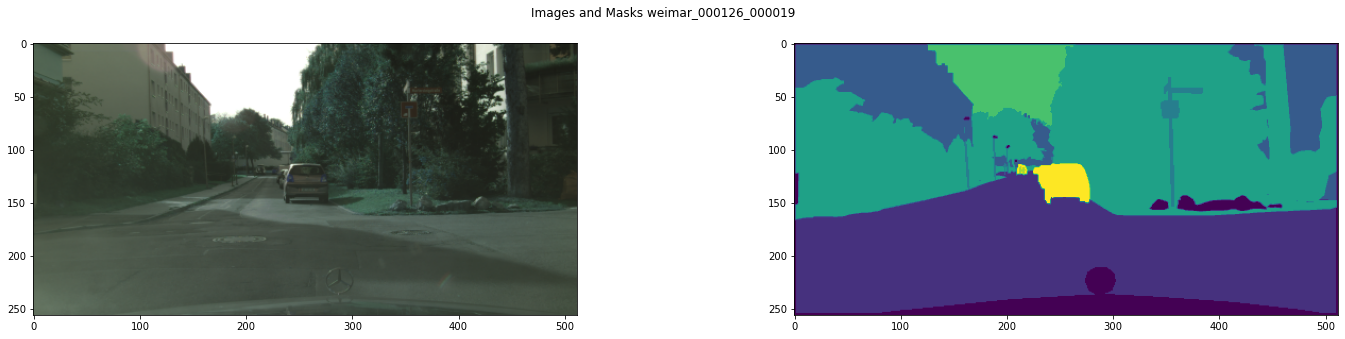

original height was  1024  and new height is  256
original width was  2048  and new width is  512
original channels was  3  and new channels is  3
----------------Normalized Image and Mask 0 from batch collected-----------------


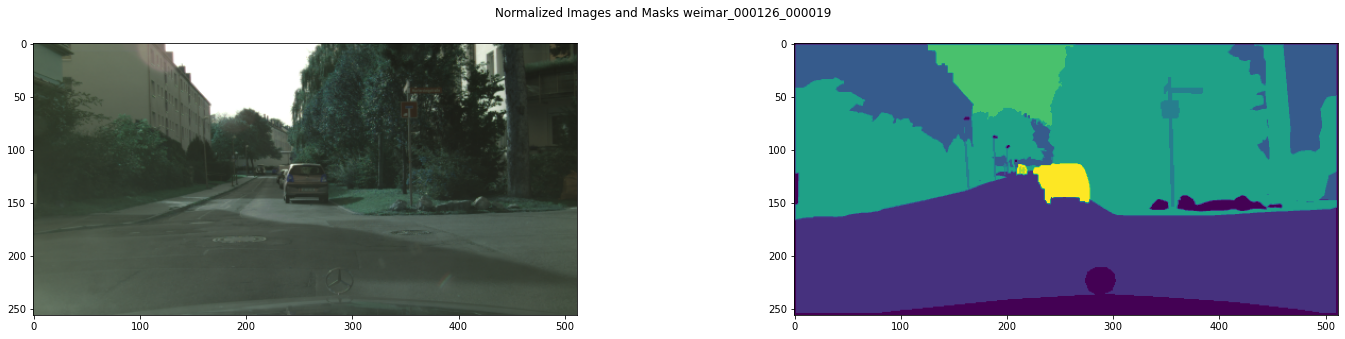

----------------Augmented Image and Mask 0 from batch collected-----------------


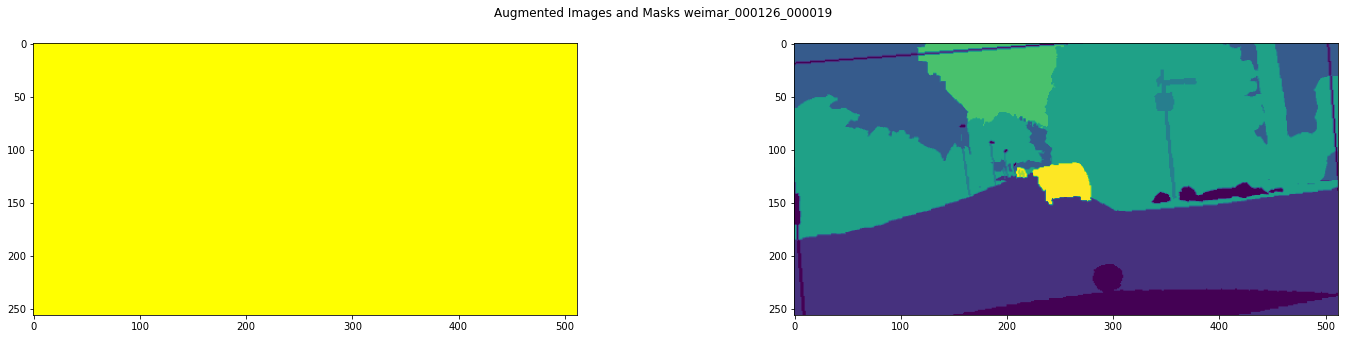

---------------- Image and Mask 0 from batch collected in Data Generator-----------------


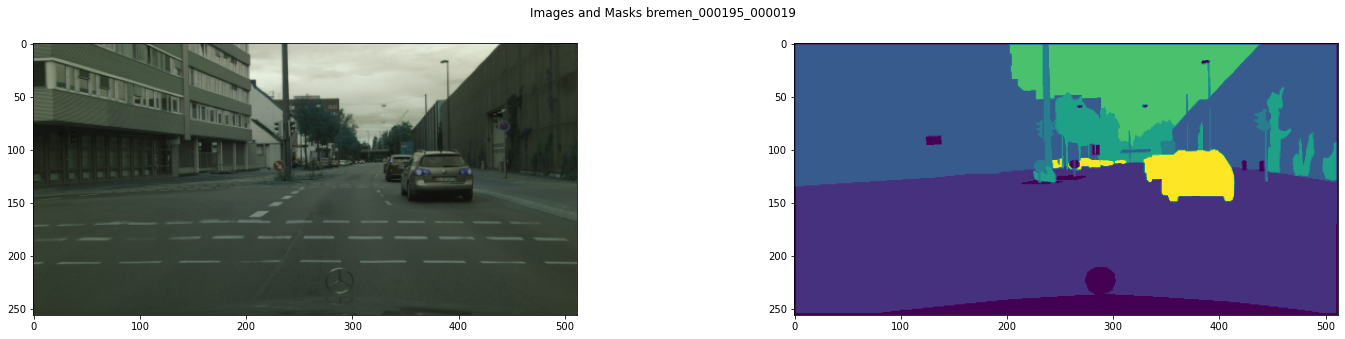

original height was  1024  and new height is  256
original width was  2048  and new width is  512
original channels was  3  and new channels is  3
----------------Normalized Image and Mask 1 from batch collected-----------------


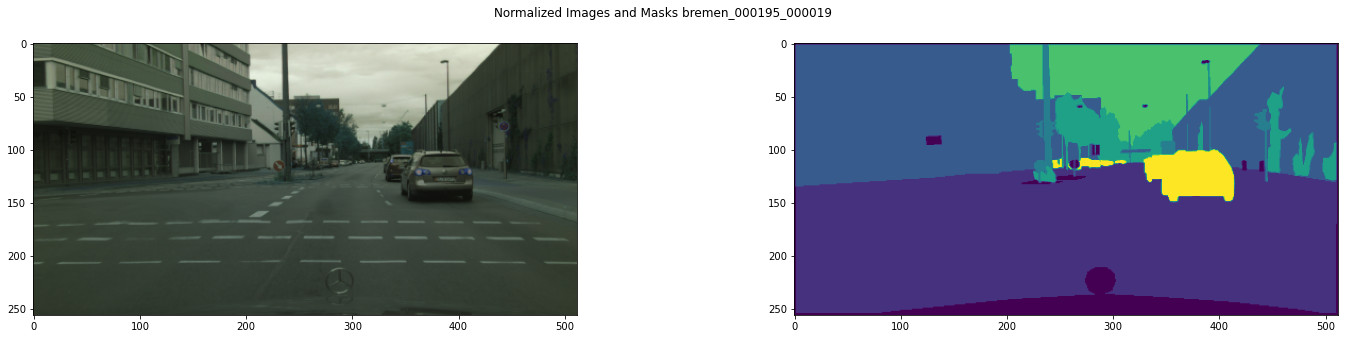

KeyError: dtype('float64')

In [21]:
dataloader[0][0].shape

Au travers du test ci-dessus, nous notons que :
 - Le format du Data Loader retourne bien les images et les masques associés, pour chaque batch
 - Les Images et masques sont correctement redimensionnés (height, Width, Channel)
 - Les Images et Masques sont augmentés (pour les données d'entrainement)
 - **Les Masques sont convertis de façon à permettre l'entrainement du modèle**
 

# Conclusions sur le Data_Generator

Nous observons au travers des tests ci-deessus que le data generator est prêt.

Néanmoins, nous allegerons un peu celui-ci, en lui retirant nombre des conditions / variables afin de le rendre plus performant.

In [1]:
# # DATALOADER - Voir Fichier Function_custo_by_Nico

In [39]:
# Divide the number of images in directory by batch_size 
n_sample = 200 #Pour les tests, nous limitons le jeu de données à 20 images
batch_size = 10 #Pour les tests, nous limitons le batch_size à 2 images
resize_width = 512
resize_height = 512
phase = 'train'
# Declare an augmentation pipeline
augmentation = None 
# augmentation = A.Compose(
#                     [#A.RandomCrop(width=512, height=256), 
#                     A.Rotate(25),
#                     A.OneOf([A.RGBShift(), A.HueSaturationValue()]),
#                     #A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0), 
#                     #A.IAAPerspective(p=0.5), 
#                     #A.HorizontalFlip(p=0.5),
#                     A.OneOf([A.CLAHE(), A.RandomBrightnessContrast(), A.RandomGamma()]), 
#                     ])

dataloader = GeneratorCitySpace(clean_df, n_sample, batch_size, resize_width, resize_height, phase, augmentation)

In [40]:
dataloader[5][1].shape

(10, 512, 512, 1)

# Création du modèle UNET

Dans le notebook suivant, nous créerons notre premier Model de segmentation sémantic, sur la base UNET
